In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, curve_fit
import astropy.units as u
import astropy.constants as const
import math
import statistics
from scipy.stats import linregress, pearsonr
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)

### Marco teórico


Para el análisis de datos se utilizaron las siguientes ecuaciones y conceptos:

- Propagación de errores: $$\left(\delta f(x_1, x_2, ...)\right)^{2} = \left(\frac{\partial f}{\partial x_1}\delta x_1\right)^{2} + \left(\frac{\partial f}{\partial x_2}\delta x_2\right)^{2} + ...$$

- Coeficiente de reflexión en polarización paralela: $$r_{||} = \frac{n_{1}\cos(\theta_t) - n_{2}\cos(\theta_i)}{n_{1}\cos(\theta_t) + n_{2}\cos(\theta_i)}$$

- Coeficiente de reflexión en polarización perpendicular: $$r_{\perp} = \frac{n_{1}\cos(\theta_i) - n_{2}\cos(\theta_t)}{n_{1}\cos(\theta_i) + n_{2}\cos(\theta_t)}$$

- Ley de Snell: $$n_1 \sin(\theta_i) = n_{2}\sin(\theta_t)$$

- Relación entre ángulo de Brewster y razón entre índices de refracción: $$\tan(\theta_B) = \frac{n_2}{n_1}$$

- Reflectividad: $$|r|$$

- Reflectancia: $$R = |r|^2 = \frac{I_{r}}{I_{o}}$$

### Parte 1: Determinación de $n_2$

Para la determinación de índice de refracción del bloque de acrílico, utilizaremos la ecuación que relaciona la razón entre los índices de refracción de dos medios con la tangente del ángulo de Brewster:

$$\frac{n_2}{n_1} = \tan (\theta_B)$$

Dado que tomamos que el índice de refracción del aire es $n_1 = 1$, podemos despejar $n_2$ de la ecuación anterior:

$$n_2 = n_1 \tan (\theta_B) = \tan (\theta_B)$$

En nuestro montaje experimental, para la polarización paralela encontramos que el ángulo de Brewster era $56° \pm 0.5°$, donde encontramos una intensidad mínima de $0.5 \mu A \pm 0.05 \mu A$. 

In [3]:
brewster_angle = 56 * u.deg
err_brewster = 0.5 * u.deg
n_2_literature = 1.49

In [8]:
teo_brewster = (np.arctan(n_2_literature) * u.rad).to(u.deg)
teo_brewster

<Quantity 56.13282089 deg>

In [4]:
n_2 = np.tan(brewster_angle) 
err_n_2 = np.tan(brewster_angle + err_brewster) - np.tan(brewster_angle)

percent_diff = np.abs(n_2 - n_2_literature) / n_2_literature * 100
err_percent_diff = (np.abs(n_2 + err_n_2 - n_2_literature) / n_2_literature * 100) - percent_diff 

print("n_2 =  "+ str(np.round(n_2, 3)) + " ± " + str(np.round(err_n_2, 3)))
print("Diferencia porcentual = " + str(np.round(percent_diff, 3)) + " ± " + str(np.round(err_percent_diff, 3)) + "%")

n_2 =  1.483 ± 0.028
Diferencia porcentual = 0.499 ± 0.899%


Así, evaluando nuestro resultado para el ángulo de Brewster, considerando los errores, encontramos que el índice de refracción del acrílico es $n_2 = 1.483 \pm 0.028$, el cual difiere en $0.499 \pm 0.899\%$ del valor encontrado en la literatura de $n_2 = 1.49$ (Beadie et al., 2015)

### Parte 2: Reflectancia

Para todos los datos obtenidos de intensidades reflejadas para cada ángulo, se calculó la reflectancia $R$ de cada uno de ellos utilizando la razón entre estas intensidades y la intensidad incidente. El resultado de este cálculo se muestra en el siguiente gráfico, junto con las curva teóricas de reflectancia para el acrílico, para cada respectiva polarización, para lo cual se calcularon los ángulos de transmisión a través de la ley de Snell.

In [108]:
def snell_law(theta_i, theta_err, n_2, n_2_err):
    theta_t = (np.arcsin(np.sin(theta_i) / n_2)).to(u.deg)
    theta_t_err = (theta_t * np.sqrt((theta_err / theta_i)**2 + (n_2_err / n_2)**2)).to(u.deg)
    return theta_t, theta_t_err

def reflx_coef_parallel(theta_t, theta_t_err, theta_i, theta_i_err, n_2, n_2_err):
    num = np.cos(theta_t) - n_2 * np.cos(theta_i)
    den = np.cos(theta_t) + n_2 * np.cos(theta_i)
    reflx_coef = num / den
    return reflx_coef

def reflx_coef_perp(theta_t, theta_t_err, theta_i, theta_i_err, n_2, n_2_err):
    num = np.cos(theta_i) - n_2 * np.cos(theta_t)
    den = np.cos(theta_i) + n_2 * np.cos(theta_t)
    reflx_coef = num / den
    return reflx_coef


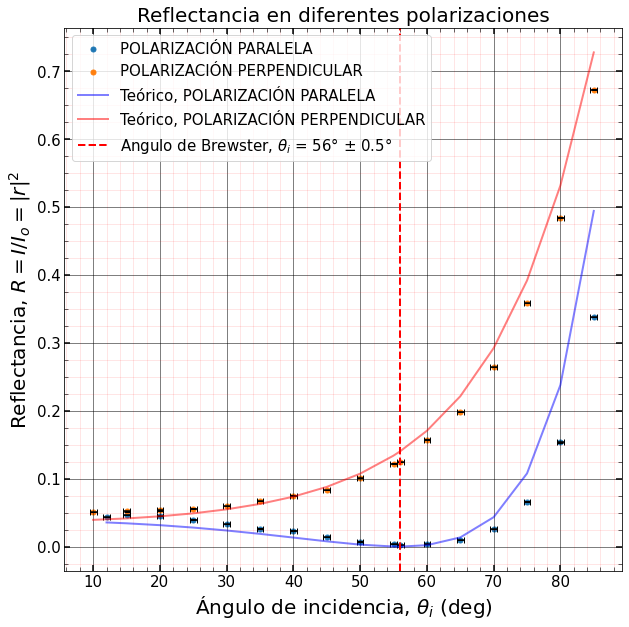

In [164]:
i_0 = 191.6 # uA
err_i = 0.05  # uA
err_theta = 0.5 # deg

# DATOS POLARIZACIÓN PARALELA
    # ángulos de incidencia e intensidades

parallel_theta_i = np.array([
    56, 12, 15, 20, 25, 30, 35, 40, 
    45, 50, 55, 60, 65, 70, 75, 80, 85
]) * u.deg

parallel_i = np.array([
    0.5, 8.4, 9.0, 8.7, 7.6, 6.3, 5.1,
    4.5, 2.7, 1.4, 0.7, 0.7, 1.8, 4.9, 12.7, 29.4, 64.7 
]) * u.uA

parallel_ierr = np.array([err_i for i in range(len(parallel_i))]) * u.uA
parallel_theta_ierr = np.array([err_theta for i in range(len(parallel_theta_i))]) * u.deg

    # ángulos de transmisión

parallel_theta_t, parallel_theta_t_err = snell_law(
    parallel_theta_i, parallel_theta_ierr, n_2, err_n_2
    )

    # coeficiente de reflexión teórico
    
parallel_r_coef = reflx_coef_parallel(
    parallel_theta_t, parallel_theta_t_err, parallel_theta_i, parallel_theta_ierr, n_2, err_n_2
    )

# DATOS POLARIZACIÓN PERPENDICULAR
    # ángulos de incidencia e intensidades

perp_theta_i = np.array([
    56, 10, 15, 20, 25, 30, 35, 40,
    45, 50, 55, 60, 65, 70, 75, 80, 85
]) * u.deg

perp_i = np.array([
    23.9, 9.7, 9.9, 10.2, 10.7, 11.5, 12.9, 14.4, 16.0, 19.4,
    23.4, 30.2, 37.9, 50.6, 68.7, 92.8, 128.9
]) * u.uA

perp_ierr = np.array([err_i for i in range(len(perp_i))]) * u.uA
perp_theta_ierr = np.array([err_theta for i in range(len(perp_theta_i))]) * u.deg

    # ángulos de transmisión

perp_theta_t, perp_theta_t_err = snell_law(
    perp_theta_i, perp_theta_ierr, n_2, err_n_2
    )

    # coeficiente de reflexión teórico

perp_r_coef = reflx_coef_perp(
    perp_theta_t, perp_theta_t_err, perp_theta_i, perp_theta_ierr, n_2, err_n_2
    )

array_i_0 = np.array([i_0 for i in range(len(parallel_i))]) * u.uA


x = parallel_theta_i 
y = parallel_i / array_i_0
x1 = perp_theta_i
y1 = perp_i / array_i_0

# calculate y and y1 errors, knowing that the error of array_i_0 is err_i

y_err = np.sqrt((parallel_ierr / array_i_0)**2 + (parallel_i * parallel_ierr / array_i_0**2)**2)
y_1_err = np.sqrt((perp_ierr / array_i_0)**2 + (perp_i * perp_ierr / array_i_0**2)**2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y, marker='.', s=100, label='POLARIZACIÓN PARALELA')
ax.scatter(x1, y1, marker='.', s=100, label='POLARIZACIÓN PERPENDICULAR')
# agrega barras de error
ax.errorbar(x, y, xerr=parallel_theta_ierr, yerr=y_err, fmt='none', ecolor='black', capsize=3)
ax.errorbar(x1, y1, xerr=perp_theta_ierr, yerr=y_1_err, fmt='none', ecolor='black', capsize=3)

ax.plot(x[np.argsort(x)], parallel_r_coef[np.argsort(x)]**2, color='blue', linewidth=2, linestyle='-', label='Teórico, POLARIZACIÓN PARALELA', alpha=0.5)
ax.plot(x1[np.argsort(x1)], perp_r_coef[np.argsort(x1)]**2, color='red', linewidth=2, linestyle='-', label='Teórico, POLARIZACIÓN PERPENDICULAR', alpha=0.5)


ax.set_ylabel(r'Reflectancia, $R = I/I_o = |r|^2$', fontsize=20)
ax.set_xlabel(r'Ángulo de incidencia, $\theta_i$ (deg)', fontsize=20)
ax.set_title('Reflectancia en diferentes polarizaciones', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.axvline(56, color='red', linewidth=2, linestyle='--', label=r'Angulo de Brewster, $\theta_i$ = 56° $\pm$ 0.5°')

# # haz que el eje de arriba muestre los ángulos del eje x pero en radianes

# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks(ax.get_xticks())
# ax2.set_xticklabels(np.round(np.deg2rad(ax.get_xticks()), 2))
# ax2.set_xlabel(r'Ángulo de incidencia, $\theta_i$ (rad)', fontsize=20)
# ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
#                 length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
#                 grid_linewidth=0.5)

# ax.text(0.05, 0.50, r'$n_2 = 1.483 ± 0.028$', transform=ax.transAxes, fontsize=20,
#         verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

ax.grid(True, which='both')
ax.legend(fontsize=15, markerscale=1)

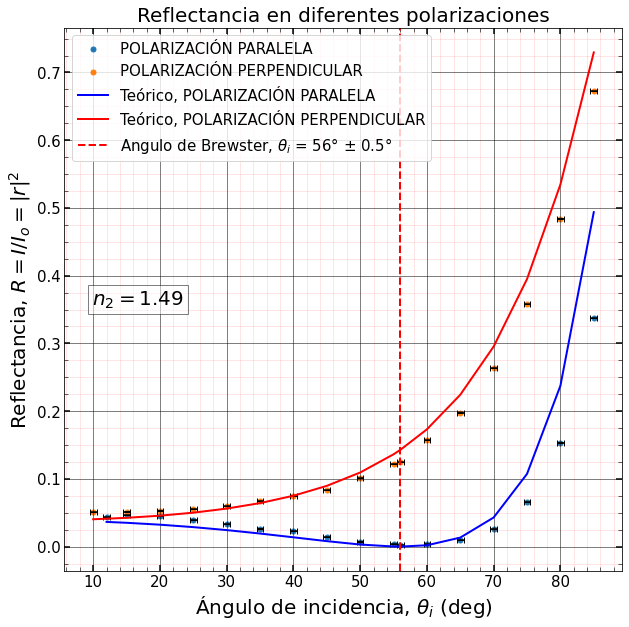

In [153]:
i_0 = 191.6 # uA
err_i = 0.05  # uA
err_theta = 0.5 # deg

# DATOS POLARIZACIÓN PARALELA
    # ángulos de incidencia e intensidades

parallel_theta_i = np.array([
    56, 12, 15, 20, 25, 30, 35, 40, 
    45, 50, 55, 60, 65, 70, 75, 80, 85
]) * u.deg

parallel_i = np.array([
    0.5, 8.4, 9.0, 8.7, 7.6, 6.3, 5.1,
    4.5, 2.7, 1.4, 0.7, 0.7, 1.8, 4.9, 12.7, 29.4, 64.7 
]) * u.uA

parallel_ierr = np.array([err_i for i in range(len(parallel_i))]) * u.uA
parallel_theta_ierr = np.array([err_theta for i in range(len(parallel_theta_i))]) * u.deg

    # ángulos de transmisión

parallel_theta_t, parallel_theta_t_err = snell_law(
    parallel_theta_i, parallel_theta_ierr, 1.49, err_n_2
    )

    # coeficiente de reflexión teórico
    
parallel_r_coef = reflx_coef_parallel(
    parallel_theta_t, parallel_theta_t_err, parallel_theta_i, parallel_theta_ierr, 1.49, err_n_2
    )

# DATOS POLARIZACIÓN PERPENDICULAR
    # ángulos de incidencia e intensidades

perp_theta_i = np.array([
    56, 10, 15, 20, 25, 30, 35, 40,
    45, 50, 55, 60, 65, 70, 75, 80, 85
]) * u.deg

perp_i = np.array([
    23.9, 9.7, 9.9, 10.2, 10.7, 11.5, 12.9, 14.4, 16.0, 19.4,
    23.4, 30.2, 37.9, 50.6, 68.7, 92.8, 128.9
]) * u.uA

perp_ierr = np.array([err_i for i in range(len(perp_i))]) * u.uA
perp_theta_ierr = np.array([err_theta for i in range(len(perp_theta_i))]) * u.deg

    # ángulos de transmisión

perp_theta_t, perp_theta_t_err = snell_law(
    perp_theta_i, perp_theta_ierr, 1.49, err_n_2
    )

    # coeficiente de reflexión teórico

perp_r_coef = reflx_coef_perp(
    perp_theta_t, perp_theta_t_err, perp_theta_i, perp_theta_ierr, 1.49, err_n_2
    )

array_i_0 = np.array([i_0 for i in range(len(parallel_i))]) * u.uA


x = parallel_theta_i 
y = parallel_i / array_i_0
x1 = perp_theta_i
y1 = perp_i / array_i_0

# calculate y and y1 errors, knowing that the error of array_i_0 is err_i

y_err = np.sqrt((parallel_ierr / array_i_0)**2 + (parallel_i * parallel_ierr / array_i_0**2)**2)
y_1_err = np.sqrt((perp_ierr / array_i_0)**2 + (perp_i * perp_ierr / array_i_0**2)**2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y, marker='.', s=100, label='POLARIZACIÓN PARALELA')
ax.scatter(x1, y1, marker='.', s=100, label='POLARIZACIÓN PERPENDICULAR')
# agrega barras de error
ax.errorbar(x, y, xerr=parallel_theta_ierr, yerr=y_err, fmt='none', ecolor='black', capsize=3)
ax.errorbar(x1, y1, xerr=perp_theta_ierr, yerr=y_1_err, fmt='none', ecolor='black', capsize=3)

ax.plot(x[np.argsort(x)], parallel_r_coef[np.argsort(x)]**2, color='blue', linewidth=2, linestyle='-', label='Teórico, POLARIZACIÓN PARALELA')
ax.plot(x1[np.argsort(x1)], perp_r_coef[np.argsort(x1)]**2, color='red', linewidth=2, linestyle='-', label='Teórico, POLARIZACIÓN PERPENDICULAR')


ax.set_ylabel(r'Reflectancia, $R = I/I_o = |r|^2$', fontsize=20)
ax.set_xlabel(r'Ángulo de incidencia, $\theta_i$ (deg)', fontsize=20)
ax.set_title('Reflectancia en diferentes polarizaciones', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.axvline(56, color='red', linewidth=2, linestyle='--', label=r'Angulo de Brewster, $\theta_i$ = 56° $\pm$ 0.5°')

# add a label

ax.text(0.05, 0.50, r'$n_2 = 1.49$', transform=ax.transAxes, fontsize=20,
        verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

ax.grid(True, which='both')
ax.legend(fontsize=15, markerscale=1)

### Parte 3: Reflectividad

Dado que en la parte anterior del experimento se calculó la reflectancia $R$ para cada ángulo, podemos calcular la reflectividad $|r|$ para cada ángulo utilizando la ecuación que relaciona ambas cantidades, $R = |r|^2$.

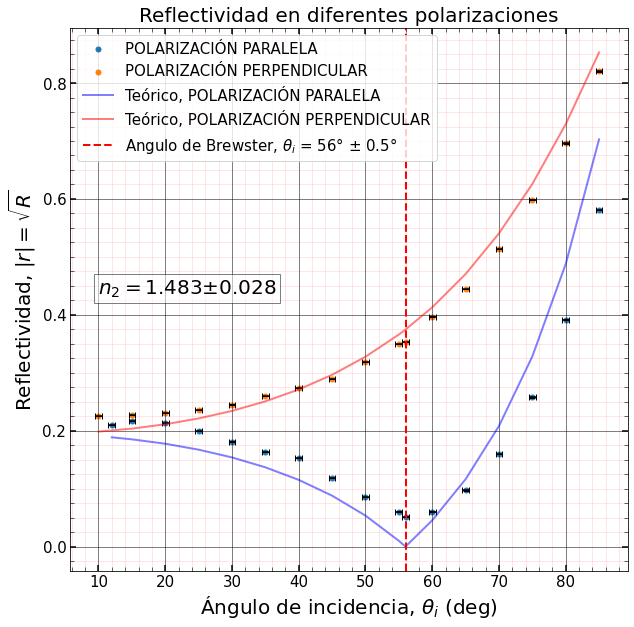

In [156]:
i_0 = 191.6 # uA
err_i = 0.05  # uA
err_theta = 0.5 # deg

# DATOS POLARIZACIÓN PARALELA
    # ángulos de incidencia e intensidades

parallel_theta_i = np.array([
    56, 12, 15, 20, 25, 30, 35, 40, 
    45, 50, 55, 60, 65, 70, 75, 80, 85
]) * u.deg

parallel_i = np.array([
    0.5, 8.4, 9.0, 8.7, 7.6, 6.3, 5.1,
    4.5, 2.7, 1.4, 0.7, 0.7, 1.8, 4.9, 12.7, 29.4, 64.7 
]) * u.uA

parallel_ierr = np.array([err_i for i in range(len(parallel_i))]) * u.uA
parallel_theta_ierr = np.array([err_theta for i in range(len(parallel_theta_i))]) * u.deg

    # ángulos de transmisión

parallel_theta_t, parallel_theta_t_err = snell_law(
    parallel_theta_i, parallel_theta_ierr, n_2, err_n_2
    )

    # coeficiente de reflexión teórico
    
parallel_r_coef = reflx_coef_parallel(
    parallel_theta_t, parallel_theta_t_err, parallel_theta_i, parallel_theta_ierr, n_2, err_n_2
    )

# DATOS POLARIZACIÓN PERPENDICULAR
    # ángulos de incidencia e intensidades

perp_theta_i = np.array([
    56, 10, 15, 20, 25, 30, 35, 40,
    45, 50, 55, 60, 65, 70, 75, 80, 85
]) * u.deg

perp_i = np.array([
    23.9, 9.7, 9.9, 10.2, 10.7, 11.5, 12.9, 14.4, 16.0, 19.4,
    23.4, 30.2, 37.9, 50.6, 68.7, 92.8, 128.9
]) * u.uA

perp_ierr = np.array([err_i for i in range(len(perp_i))]) * u.uA
perp_theta_ierr = np.array([err_theta for i in range(len(perp_theta_i))]) * u.deg

    # ángulos de transmisión

perp_theta_t, perp_theta_t_err = snell_law(
    perp_theta_i, perp_theta_ierr, n_2, err_n_2
    )

    # coeficiente de reflexión teórico

perp_r_coef = reflx_coef_perp(
    perp_theta_t, perp_theta_t_err, perp_theta_i, perp_theta_ierr, n_2, err_n_2
    )

array_i_0 = np.array([i_0 for i in range(len(parallel_i))]) * u.uA


x = parallel_theta_i 
y = np.sqrt(parallel_i / array_i_0)
x1 = perp_theta_i
y1 = np.sqrt(perp_i / array_i_0)

# calculate y and y1 errors, knowing that the error of array_i_0 is err_i

y_err = np.sqrt((parallel_ierr / array_i_0)**2 + (parallel_i * parallel_ierr / array_i_0**2)**2)
y_1_err = np.sqrt((perp_ierr / array_i_0)**2 + (perp_i * perp_ierr / array_i_0**2)**2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y, marker='.', s=100, label='POLARIZACIÓN PARALELA')
ax.scatter(x1, y1, marker='.', s=100, label='POLARIZACIÓN PERPENDICULAR')
# agrega barras de error
ax.errorbar(x, y, xerr=parallel_theta_ierr, yerr=y_err, fmt='none', ecolor='black', capsize=3)
ax.errorbar(x1, y1, xerr=perp_theta_ierr, yerr=y_1_err, fmt='none', ecolor='black', capsize=3)

ax.plot(x[np.argsort(x)], np.abs(parallel_r_coef[np.argsort(x)]), color='blue', linewidth=2, linestyle='-', label='Teórico, POLARIZACIÓN PARALELA', alpha=0.5)
ax.plot(x1[np.argsort(x1)], np.abs(perp_r_coef[np.argsort(x1)]), color='red', linewidth=2, linestyle='-', label='Teórico, POLARIZACIÓN PERPENDICULAR', alpha=0.5)


ax.set_ylabel(r'Reflectividad, $|r| = \sqrt{R}$', fontsize=20)
ax.set_xlabel(r'Ángulo de incidencia, $\theta_i$ (deg)', fontsize=20)
ax.set_title('Reflectividad en diferentes polarizaciones', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.axvline(56, color='red', linewidth=2, linestyle='--', label=r'Angulo de Brewster, $\theta_i$ = 56° $\pm$ 0.5°')

ax.text(0.05, 0.52, r'$n_2 = 1.483 ± 0.028$', transform=ax.transAxes, fontsize=20,
        verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

ax.grid(True, which='both')
ax.legend(fontsize=15, markerscale=1)

### Bibliografía

- Beadie, G., Brindza, M. R., Flynn, R. A., Rosenberg, A., & Shirk, J. S. (2015). Refractive index measurements of poly(methyl methacrylate) (PMMA) from 04–16 μm. Applied optics, 54(31), F139. https://doi.org/10.1364/ao.54.00f139